# Redes neuronales

En este notebook clasificaremos si una instancia tiene alto poder adquisitivo mediante redes neuronales.

Se utilizarán dos preprocessings diferentes:

* PCA con el 90% de la varianza explicada

* Preprocessing primera parte

* Preprocessing mejores features de un árbol

In [1]:
# Red neuronal
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Model

# Otros
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import utils
from preprocessing import preprocessing_significantes
from preprocessing import standard_preprocessing_base_parte_1
from preprocessing import standard_preprocessing_mejores_por_arbol

# Metricas
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

In [2]:
df = utils.get_data()

## Modelo 1 - Significantes 90% varianza

Entrenaremos una red neuronal relativamente grande, pero bien regularizada:

* 66 Nodos de entrada. (con regularización l1 y l2)

* 50 Nodos en capa oculta (con dropout de 50% y regularización l2) [Relu]

* 20 Nodos en capa oculta (con dropout de 20% y regularización l2) [Relu]

* 1 Nodo de output [Sigmoid]

Esto es debido a que en la entrada hay "muchas features".

In [3]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=27)

X_train_1, X_test_1 = preprocessing_significantes(X_train_1, X_test_1, variance=0.90)

/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['ganancia_perdida_declarada_bolsa_argentina'].apply(

#### Creando la red neuronal

In [4]:
n_in = X_train_1.shape[1]

m1 = Sequential([
  Dense(n_in,
        input_dim=n_in,
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0001, l2=0.001)),
  Dense(50,
        activation='relu',
        kernel_regularizer='l2'),
  Dropout(0.50),
  Dense(20,
        activation='relu',
        kernel_regularizer='l2'),
  Dropout(0.20),
  Dense(1, activation='sigmoid')
])

In [5]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
m1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [6]:
m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 66)                4422      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3350      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 8,813
Trainable params: 8,813
Non-trainable params: 0
______________________________________________________

Vemos que tinee 8.813 parámetros a estimar. Pondremos `batch_size` de 10 para acelerar el proceso.

#### Entrenando

In [7]:
h1 = m1.fit(X_train_1, y_train_1, epochs=100, batch_size=10, verbose=1, validation_split=0.1)

Epoch 1/100
2198/2198 [==============================] - 4s 1ms/step - loss: 1.4834 - accuracy: 0.6908 - auc: 0.5996 - val_loss: 1.0735 - val_accuracy: 0.8112 - val_auc: 0.8591
Epoch 2/100
2198/2198 [==============================] - 3s 1ms/step - loss: 1.0372 - accuracy: 0.8020 - auc: 0.8292 - val_loss: 0.8447 - val_accuracy: 0.8231 - val_auc: 0.8741
Epoch 3/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.8249 - accuracy: 0.8073 - auc: 0.8534 - val_loss: 0.6951 - val_accuracy: 0.8256 - val_auc: 0.8780
Epoch 4/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.6688 - accuracy: 0.8249 - auc: 0.8716 - val_loss: 0.5980 - val_accuracy: 0.8280 - val_auc: 0.8782
Epoch 5/100
2198/2198 [==============================] - 2s 1ms/step - loss: 0.5822 - accuracy: 0.8210 - auc: 0.8748 - val_loss: 0.5349 - val_accuracy: 0.8276 - val_auc: 0.8803
Epoch 6/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.5237 - accuracy: 0.8288 - auc: 0.879

2198/2198 [==============================] - 3s 1ms/step - loss: 0.3701 - accuracy: 0.8374 - auc: 0.8845 - val_loss: 0.3768 - val_accuracy: 0.8247 - val_auc: 0.8836
Epoch 94/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.3703 - accuracy: 0.8361 - auc: 0.8834 - val_loss: 0.3771 - val_accuracy: 0.8260 - val_auc: 0.8834
Epoch 95/100
2198/2198 [==============================] - 4s 2ms/step - loss: 0.3671 - accuracy: 0.8360 - auc: 0.8885 - val_loss: 0.3767 - val_accuracy: 0.8260 - val_auc: 0.8836
Epoch 96/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.3648 - accuracy: 0.8380 - auc: 0.8868 - val_loss: 0.3769 - val_accuracy: 0.8276 - val_auc: 0.8836
Epoch 97/100
2198/2198 [==============================] - 2s 1ms/step - loss: 0.3630 - accuracy: 0.8421 - auc: 0.8888 - val_loss: 0.3772 - val_accuracy: 0.8256 - val_auc: 0.8838
Epoch 98/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.3641 - accuracy: 0.8390 - auc: 0.8865 - val

### Métricas

Veamos cómo se comportó la pérdida (`binary_crossentropy`) a lo largo de las épocas, queremos ver si el modelo puede entrenar más o si "se estancó", además también percibir si hubo overfitting o underfitting evaluando las curvas de loss y la de validation_loss.

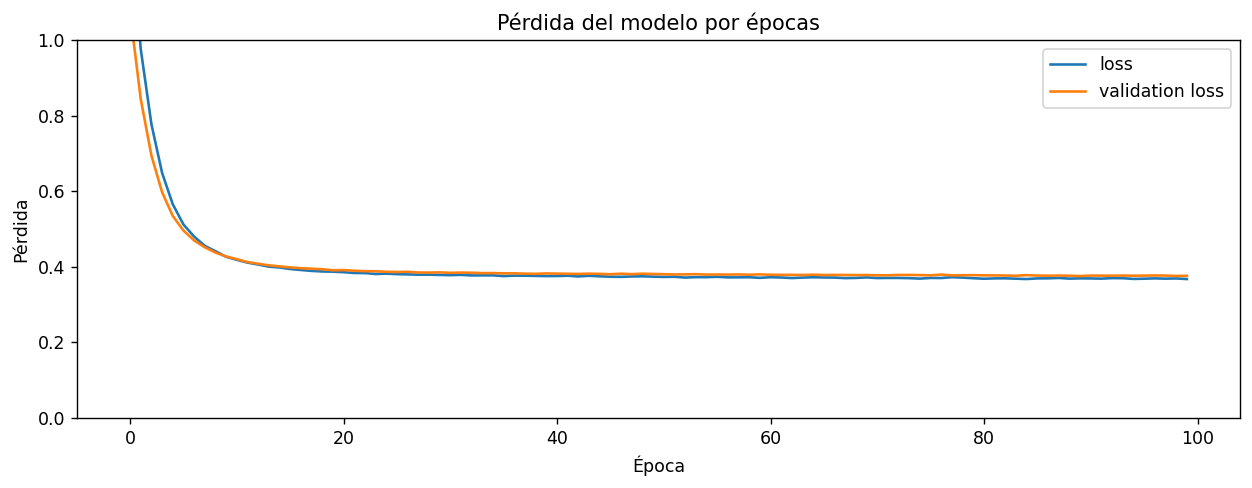

In [8]:
plt.figure(dpi=125, figsize=(12, 4))
plt.plot(h1.history['loss'], label="loss")
plt.plot(h1.history['val_loss'], label="validation loss")
plt.title('Pérdida del modelo por épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.ylim(0, 1)
plt.legend()
plt.show()

Vemos que las curvas están pegadas, lo que quiere decir que a priori la red hizo un buen trabajo con respecto al sobreajuste y el desajuste.

Además podemos ver que la pérdida luego de la época 50 aproximadamente se mantuvo constante. Por lo que deducimos que seguramente el modelo terminó de entrenar.

Veamos entonces las métricas que nos interesan, que en este caso son las de RocAUC y accuracy.

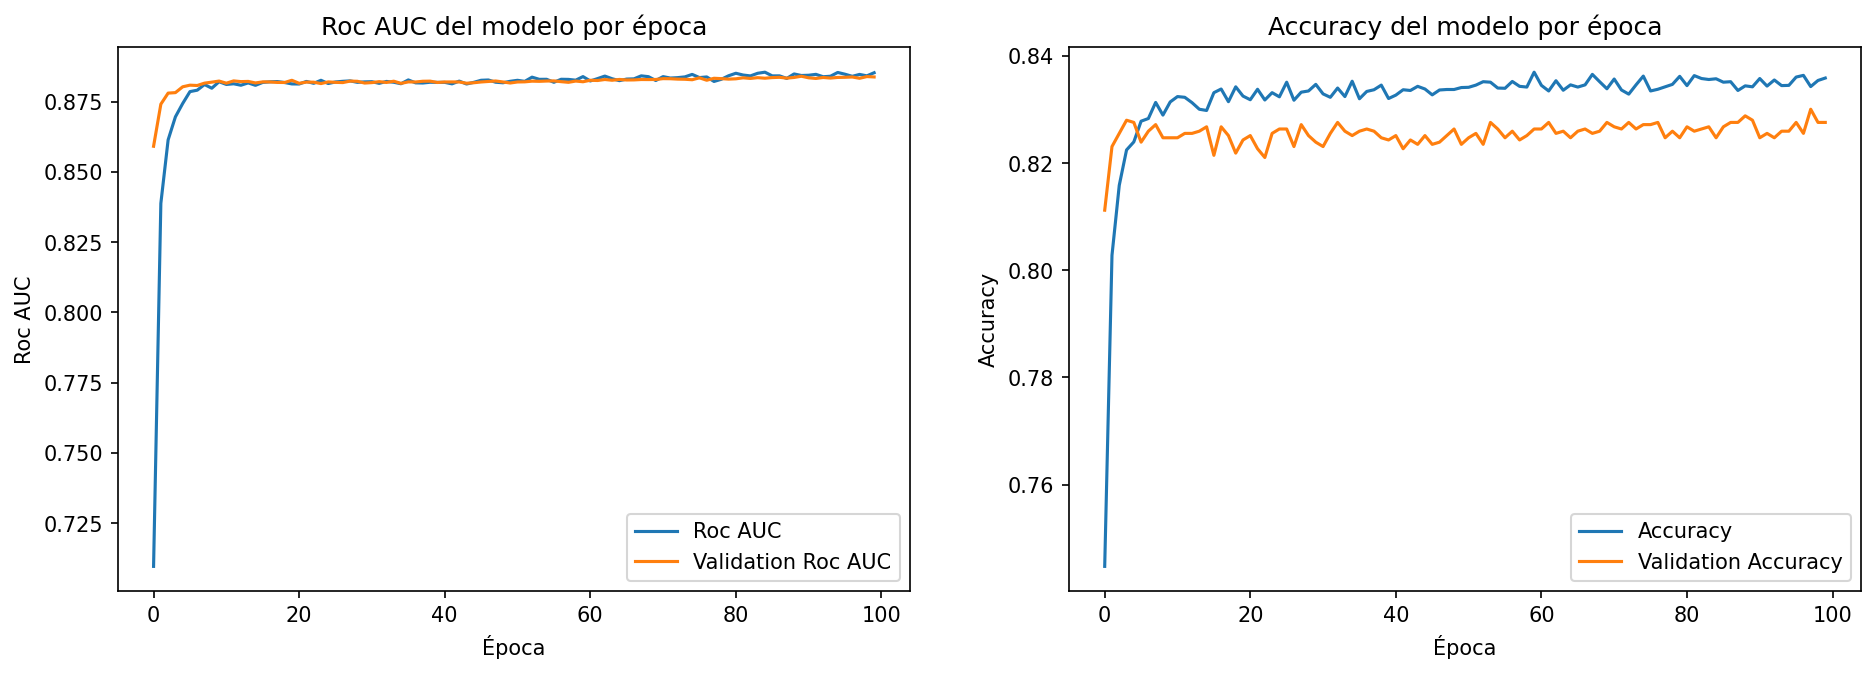

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

ax1.plot(h1.history['auc'], label="Roc AUC")
ax1.plot(h1.history['val_auc'], label="Validation Roc AUC")
ax1.set_title('Roc AUC del modelo por época')
ax1.set_ylabel('Roc AUC')
ax1.set_xlabel('Época')
ax1.legend()

ax2.plot(h1.history['accuracy'], label="Accuracy")
ax2.plot(h1.history['val_accuracy'], label="Validation Accuracy")
ax2.set_title('Accuracy del modelo por época')

ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Época')
ax2.legend()


plt.show()

Podemos ver en la figura de la izquierda que el RocAUC de validación da constantemente superior al de train.

Pero podemos ver en la figura de la derecha que el Accuracy de entrenamiento está constantemente por encima de validación.

De todas formas la diferencia es mínima, y las curvas crecen con sintonía, por lo que creemos que el modelo realizó un buen trabajo.


Veamos todas las métricas

In [10]:
print(classification_report(y_test_1, m1.predict(X_test_1, verbose=4) > 0.50, digits=4))

              precision    recall  f1-score   support

           0     0.8767    0.9218    0.8987      6186
           1     0.7043    0.5898    0.6420      1955

    accuracy                         0.8420      8141
   macro avg     0.7905    0.7558    0.7703      8141
weighted avg     0.8353    0.8420    0.8370      8141



Vemos que se trata de un buen modelo en general, un buen accuracy cercano al 85%

Mucho recall en ceros y buena precision para estos.

Como es usual, poco recall para unos, pero también poca precision para ellos.

Veamos la curva Roc y su puntuación AUC

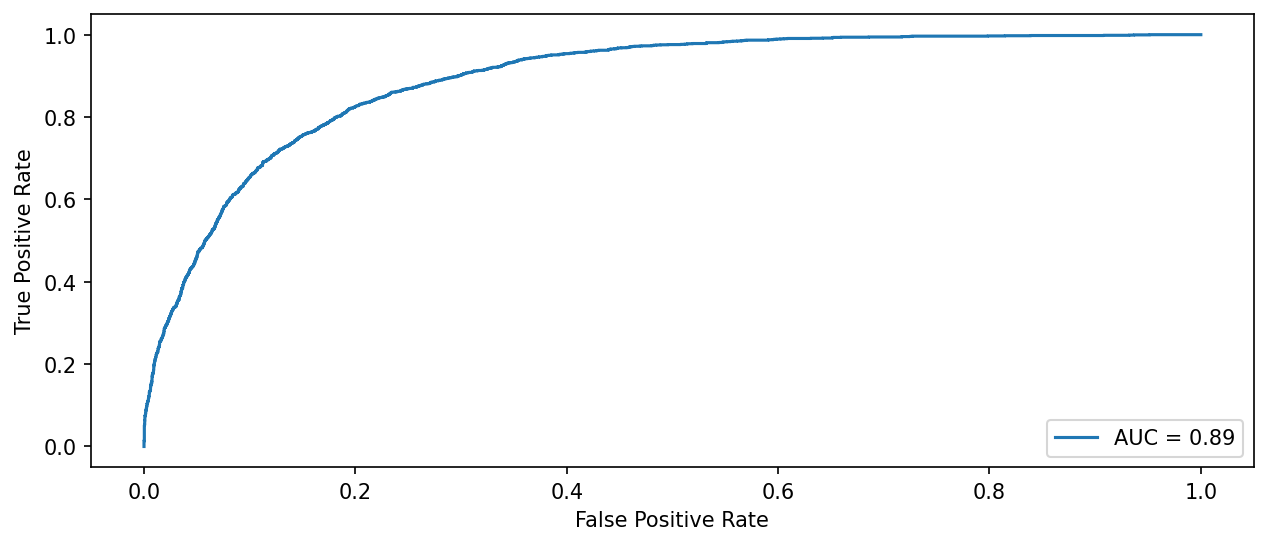

In [11]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)

fpr, tpr, thresholds = roc_curve(y_test_1, m1.predict(X_test_1))
auc = roc_auc_score(y_test_1, m1.predict(X_test_1))

r = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
r.plot(ax=ax)

plt.show()

In [12]:
auc

0.8915656424084415

Vemos que se trata de un modelo bastante bueno. Aproximadamente 89.2 de RocAUC score.

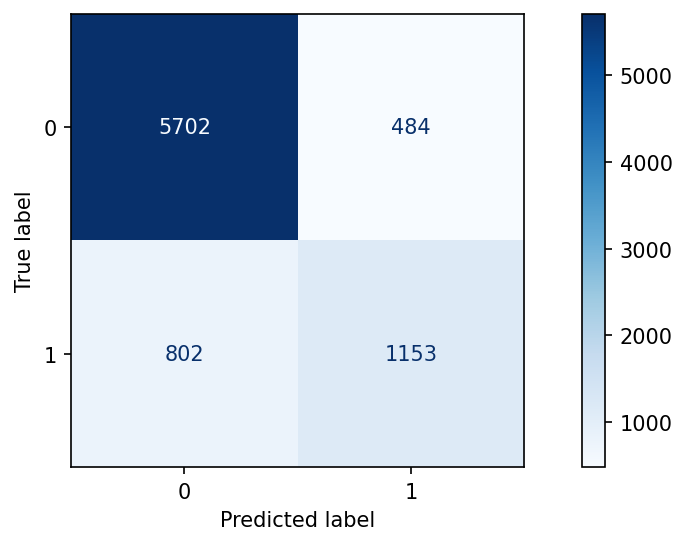

In [13]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
c = ConfusionMatrixDisplay(confusion_matrix(y_test_1, m1.predict(X_test_1)>0.5))
c.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Modelo 2 - Preprocessing parte 1

Ahora entrenaremos una red neuronal mucho más pequeña, poco regularizada

* 7 Nodos de entrada. (con regularización l2)

* 14 Nodos en capa oculta. (con dropout de 15% y regularización l2) [Relu]

* 4 Nodos en capa oculta. [Relu]

* 1 Nodo de output [Sigmoid]

Decidimos realizar una red neuronal más pequeña ya que la cantidad de entradas es menor.

In [14]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=27)

X_train_2, X_test_2 = standard_preprocessing_base_parte_1(X_train_2, X_test_2)

#### Creando la red neuronal

In [15]:
n_in = X_train_2.shape[1]

m2 = Sequential()
m2.add(Dense(n_in,
            input_dim=n_in,
            kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
m2.add(Dense(14,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(0.0001)))
m2.add(Dropout(2/14))
m2.add(Dense(4,
            activation='relu'))

m2.add(Dense(1, activation='sigmoid'))

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
m2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [17]:
m2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_5 (Dense)              (None, 14)                112       
_________________________________________________________________
dropout_2 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 60        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


Vemos que la cantidad de parámetros a estimar es muy pequeña en comparación con antes.

Entrenando

In [18]:
h2 = m2.fit(X_train_2, y_train_2, epochs=100, batch_size=10, verbose=1, validation_split=0.1)

Epoch 1/100
2198/2198 [==============================] - 4s 2ms/step - loss: 0.7692 - accuracy: 0.4029 - auc_1: 0.4343 - val_loss: 0.6482 - val_accuracy: 0.7637 - val_auc_1: 0.6625
Epoch 2/100
2198/2198 [==============================] - 2s 1ms/step - loss: 0.6388 - accuracy: 0.7689 - auc_1: 0.6287 - val_loss: 0.6051 - val_accuracy: 0.7805 - val_auc_1: 0.7448
Epoch 3/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.5921 - accuracy: 0.7992 - auc_1: 0.7479 - val_loss: 0.5500 - val_accuracy: 0.8288 - val_auc_1: 0.8418
Epoch 4/100
2198/2198 [==============================] - 4s 2ms/step - loss: 0.5409 - accuracy: 0.8321 - auc_1: 0.8137 - val_loss: 0.5124 - val_accuracy: 0.8296 - val_auc_1: 0.8462
Epoch 5/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.5082 - accuracy: 0.8294 - auc_1: 0.8203 - val_loss: 0.4855 - val_accuracy: 0.8288 - val_auc_1: 0.8479
Epoch 6/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.4806 - accuracy:

Epoch 46/100
2198/2198 [==============================] - 2s 717us/step - loss: 0.3496 - accuracy: 0.8406 - auc_1: 0.8877 - val_loss: 0.3521 - val_accuracy: 0.8325 - val_auc_1: 0.8888
Epoch 47/100
2198/2198 [==============================] - 2s 737us/step - loss: 0.3562 - accuracy: 0.8349 - auc_1: 0.8810 - val_loss: 0.3536 - val_accuracy: 0.8329 - val_auc_1: 0.8892
Epoch 48/100
2198/2198 [==============================] - 2s 783us/step - loss: 0.3529 - accuracy: 0.8364 - auc_1: 0.8834 - val_loss: 0.3509 - val_accuracy: 0.8337 - val_auc_1: 0.8896
Epoch 49/100
2198/2198 [==============================] - 2s 717us/step - loss: 0.3544 - accuracy: 0.8373 - auc_1: 0.8827 - val_loss: 0.3526 - val_accuracy: 0.8325 - val_auc_1: 0.8896
Epoch 50/100
2198/2198 [==============================] - 2s 731us/step - loss: 0.3539 - accuracy: 0.8404 - auc_1: 0.8823 - val_loss: 0.3509 - val_accuracy: 0.8342 - val_auc_1: 0.8898
Epoch 51/100
2198/2198 [==============================] - 2s 714us/step - loss: 

Epoch 91/100
2198/2198 [==============================] - 2s 1ms/step - loss: 0.3429 - accuracy: 0.8401 - auc_1: 0.8912 - val_loss: 0.3437 - val_accuracy: 0.8374 - val_auc_1: 0.8948
Epoch 92/100
2198/2198 [==============================] - 2s 971us/step - loss: 0.3467 - accuracy: 0.8390 - auc_1: 0.8876 - val_loss: 0.3446 - val_accuracy: 0.8362 - val_auc_1: 0.8948
Epoch 93/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.3368 - accuracy: 0.8436 - auc_1: 0.8947 - val_loss: 0.3435 - val_accuracy: 0.8378 - val_auc_1: 0.8946
Epoch 94/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.3417 - accuracy: 0.8408 - auc_1: 0.8928 - val_loss: 0.3437 - val_accuracy: 0.8366 - val_auc_1: 0.8945
Epoch 95/100
2198/2198 [==============================] - 3s 1ms/step - loss: 0.3407 - accuracy: 0.8411 - auc_1: 0.8922 - val_loss: 0.3426 - val_accuracy: 0.8382 - val_auc_1: 0.8948
Epoch 96/100
2198/2198 [==============================] - 2s 1ms/step - loss: 0.3431 - a

### Métricas

Veamos cómo se comportó la pérdida (`binary_crossentropy`) a lo largo de las épocas, queremos ver si el modelo puede entrenar más o si "se estancó", además también percibir si hubo overfitting o underfitting evaluando las curvas de loss y la de validation_loss.

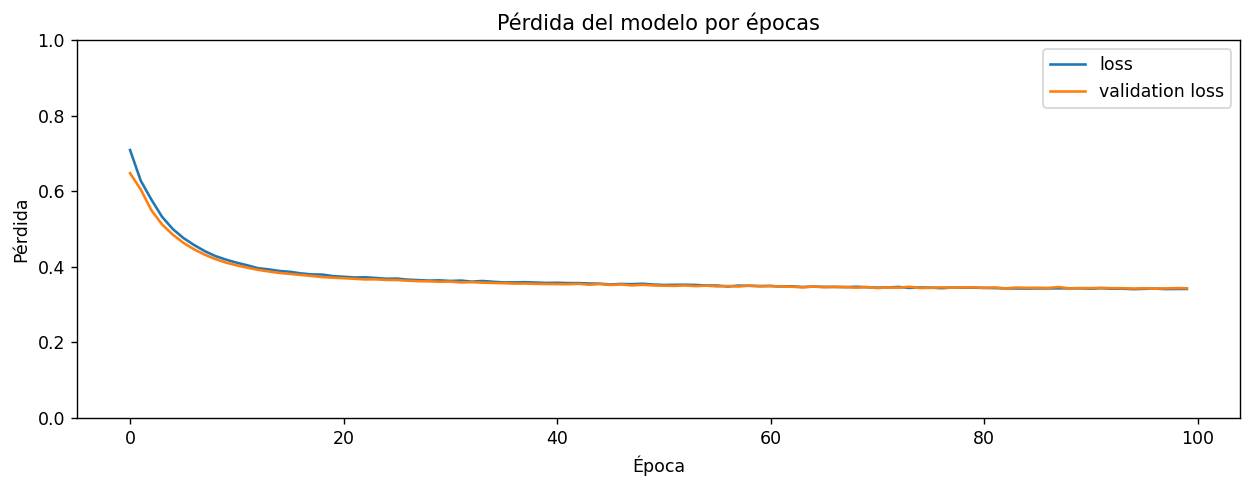

In [19]:
plt.figure(dpi=125, figsize=(12, 4))
plt.plot(h2.history['loss'], label="loss")
plt.plot(h2.history['val_loss'], label="validation loss")
plt.title('Pérdida del modelo por épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.ylim(0, 1)
plt.legend()
plt.show()

Vemos nuevamente que las curvas están pegadas. Por lo que a priori la red hizo un buen trabajo con respecto al sobreajuste y el desajuste.

A diferencia del modelo anterior, este modelo alcanza la estabilidad muy temprano, ya por la época 20 se mantiene constante la pérdida. Por lo que se ve que no son necesarias tantas épocas para obtener un buen modelo.

Veamos entonces las métricas que nos interesan, que en este caso son las de RocAUC y accuracy.

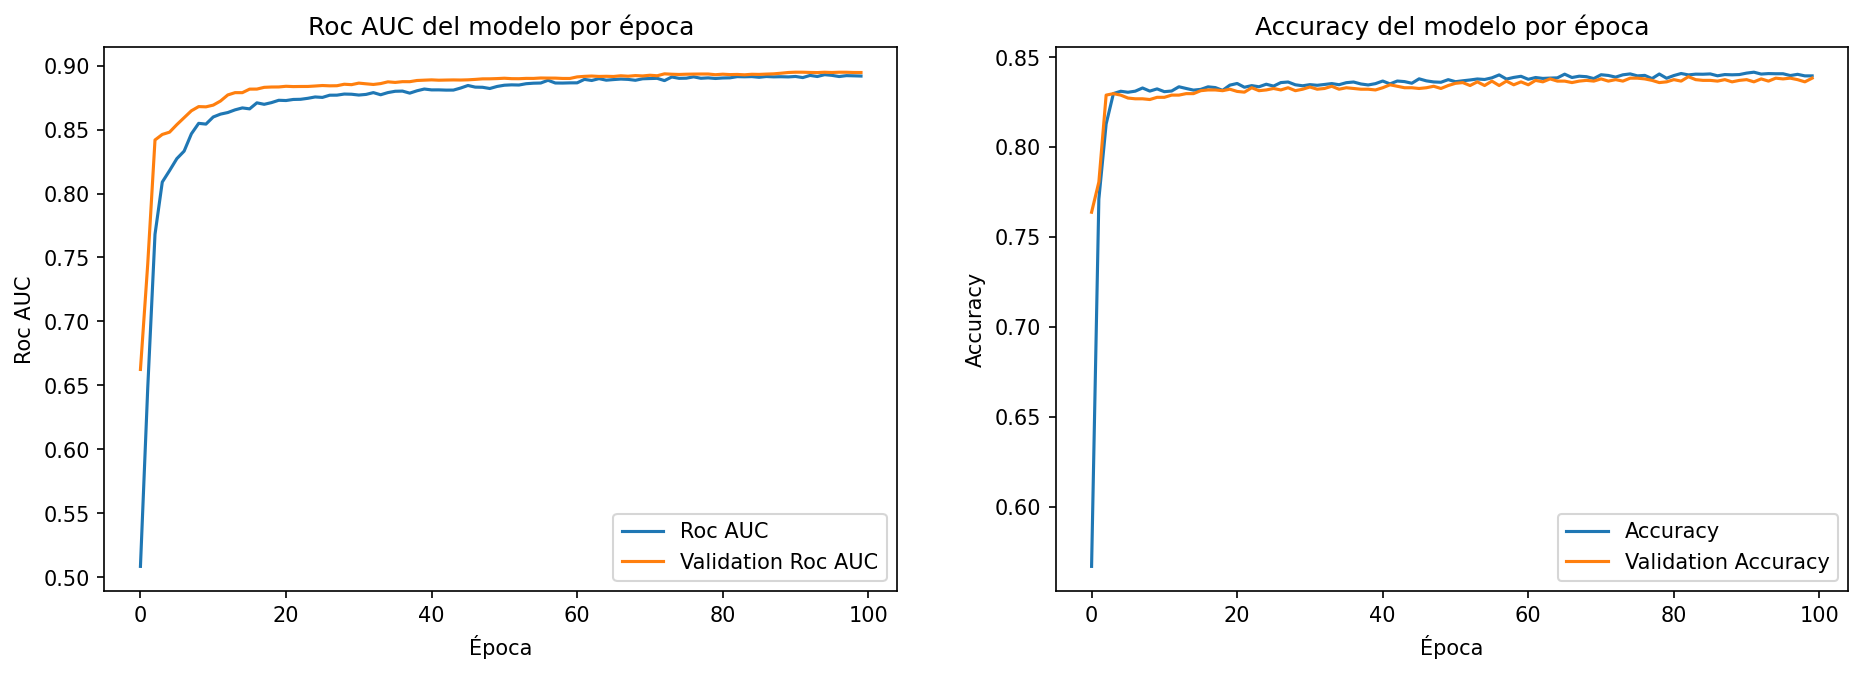

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

ax1.plot(h2.history['auc_1'], label="Roc AUC")
ax1.plot(h2.history['val_auc_1'], label="Validation Roc AUC")
ax1.set_title('Roc AUC del modelo por época')
ax1.set_ylabel('Roc AUC')
ax1.set_xlabel('Época')
ax1.legend()

ax2.plot(h2.history['accuracy'], label="Accuracy")
ax2.plot(h2.history['val_accuracy'], label="Validation Accuracy")
ax2.set_title('Accuracy del modelo por época')

ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Época')
ax2.legend()


plt.show()

Las conclusiones de las figuras son similares a las del primer modelo.

Vemos que el RocAUC se mantiene constantemente por encima en validation y no en train, a diferencia del Accuracy que en general está por encima en train.

Veamos todas las métricas

In [22]:
print(classification_report(y_test_2, m2.predict(X_test_2) > 0.50, digits=4))

              precision    recall  f1-score   support

           0     0.8653    0.9479    0.9047      6186
           1     0.7639    0.5330    0.6279      1955

    accuracy                         0.8483      8141
   macro avg     0.8146    0.7405    0.7663      8141
weighted avg     0.8409    0.8483    0.8383      8141



Un modelo interesante, se obtuvo un Accuracy de 84.6%.

Las observaciones son similares a la del modelo anterior.

Veamos la curva Roc y su puntuación AUC

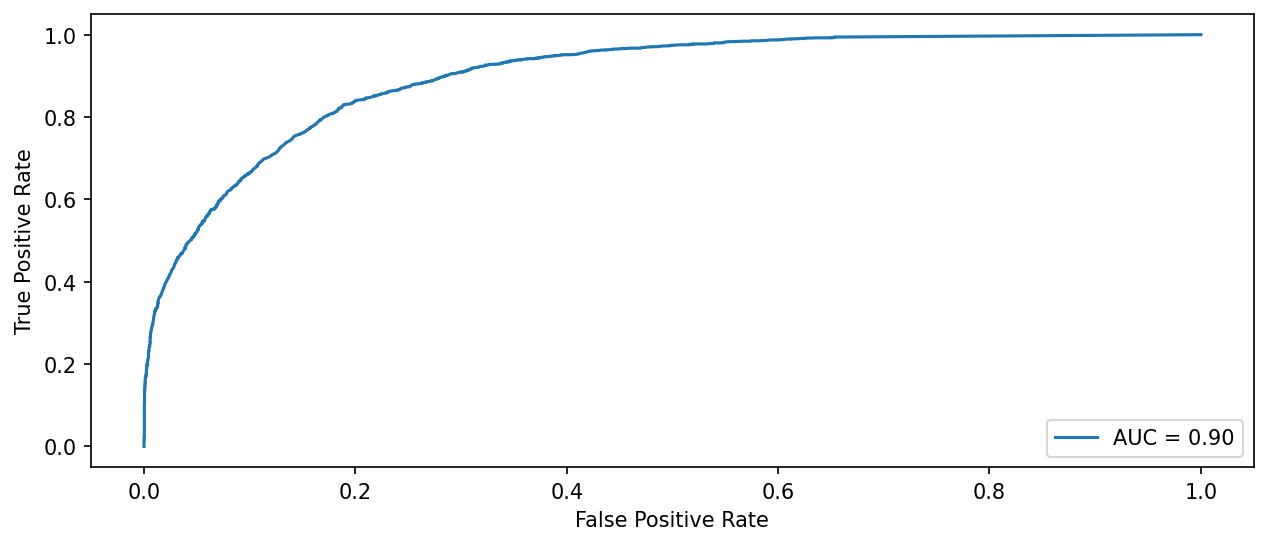

In [23]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)

fpr, tpr, thresholds = roc_curve(y_test_2, m2.predict(X_test_2))
auc = roc_auc_score(y_test_2, m2.predict(X_test_2))

r = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
r.plot(ax=ax)

plt.show()

In [24]:
auc

0.8998945725973095

Un RocAUC bueno, de 90.0%, y es entonces por ahora el mejor modelo de Redes planteado hasta ahora.

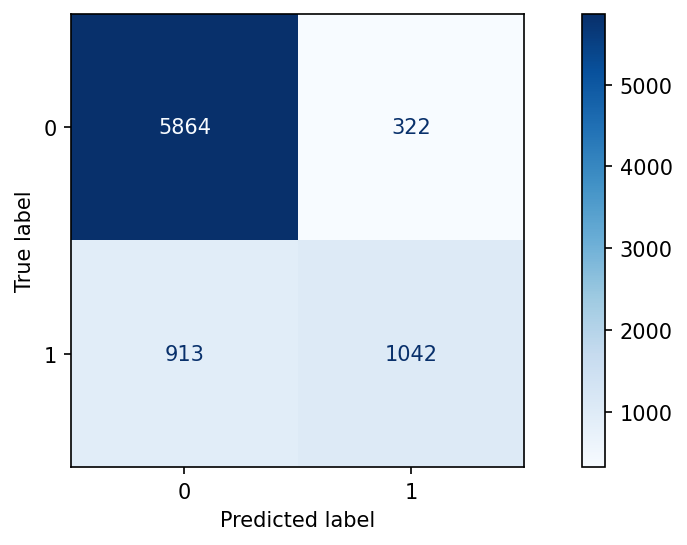

In [46]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
c = ConfusionMatrixDisplay(confusion_matrix(y_test_2, m2.predict(X_test_2)>0.5))
c.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Modelo 3 - Preprocessing standard mejores por árbol

Ahora entrenaremos una red neuronal mucho más pequeña, poco regularizada

* 8 Nodos de entrada.

* 4 Nodos en la primera capa oculta [Relu]

* 4 Nodos en la segunda capa oculta [Relu]

* 1 Nodo de output [Sigmoid]

In [25]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y, random_state=27)

X_train_3, X_test_3 = standard_preprocessing_mejores_por_arbol(X_train_3, X_test_3)

#### Creando la red neuronal

In [26]:
n_in = X_train_3.shape[1]

m3 = Sequential()
m3.add(Dense(8, input_dim=n_in))
m3.add(Dense(4, activation='relu'))
m3.add(Dense(4, activation='relu'))
m3.add(Dense(1, activation='sigmoid'))

In [27]:
m3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


Vemos que la cantidad de parámetros a estimar es muy pequeña en comparación con antes.

Entrenando

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
m3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

h3 = m3.fit(X_train_3, y_train_3, epochs=100, batch_size=25, verbose=1, validation_split=0.1)

Epoch 1/100
880/880 [==============================] - 2s 2ms/step - loss: 0.7028 - accuracy: 0.6950 - auc_2: 0.2113 - val_loss: 0.6892 - val_accuracy: 0.7469 - val_auc_2: 0.2385
Epoch 2/100
880/880 [==============================] - 1s 2ms/step - loss: 0.6862 - accuracy: 0.7582 - auc_2: 0.2383 - val_loss: 0.6748 - val_accuracy: 0.7523 - val_auc_2: 0.2711
Epoch 3/100
880/880 [==============================] - 1s 1ms/step - loss: 0.6727 - accuracy: 0.7599 - auc_2: 0.2637 - val_loss: 0.6602 - val_accuracy: 0.7523 - val_auc_2: 0.3105
Epoch 4/100
880/880 [==============================] - 1s 1ms/step - loss: 0.6551 - accuracy: 0.7634 - auc_2: 0.3041 - val_loss: 0.6453 - val_accuracy: 0.7523 - val_auc_2: 0.3605
Epoch 5/100
880/880 [==============================] - 1s 1ms/step - loss: 0.6436 - accuracy: 0.7593 - auc_2: 0.3482 - val_loss: 0.6300 - val_accuracy: 0.7523 - val_auc_2: 0.4167
Epoch 6/100
880/880 [==============================] - 1s 2ms/step - loss: 0.6277 - accuracy: 0.7598 - au

880/880 [==============================] - 1s 974us/step - loss: 0.3734 - accuracy: 0.8296 - auc_2: 0.8794 - val_loss: 0.3741 - val_accuracy: 0.8247 - val_auc_2: 0.8792
Epoch 92/100
880/880 [==============================] - 1s 1ms/step - loss: 0.3692 - accuracy: 0.8306 - auc_2: 0.8795 - val_loss: 0.3739 - val_accuracy: 0.8251 - val_auc_2: 0.8793
Epoch 93/100
880/880 [==============================] - 1s 1ms/step - loss: 0.3690 - accuracy: 0.8315 - auc_2: 0.8791 - val_loss: 0.3737 - val_accuracy: 0.8256 - val_auc_2: 0.8793
Epoch 94/100
880/880 [==============================] - 1s 1ms/step - loss: 0.3673 - accuracy: 0.8302 - auc_2: 0.8805 - val_loss: 0.3736 - val_accuracy: 0.8260 - val_auc_2: 0.8793
Epoch 95/100
880/880 [==============================] - 1s 1ms/step - loss: 0.3681 - accuracy: 0.8292 - auc_2: 0.8806 - val_loss: 0.3734 - val_accuracy: 0.8264 - val_auc_2: 0.8794
Epoch 96/100
880/880 [==============================] - 1s 1ms/step - loss: 0.3630 - accuracy: 0.8356 - auc_2: 

### Métricas

Veamos cómo se comportó la pérdida (`binary_crossentropy`) a lo largo de las épocas, queremos ver si el modelo puede entrenar más o si "se estancó", además también percibir si hubo overfitting o underfitting evaluando las curvas de loss y la de validation_loss.

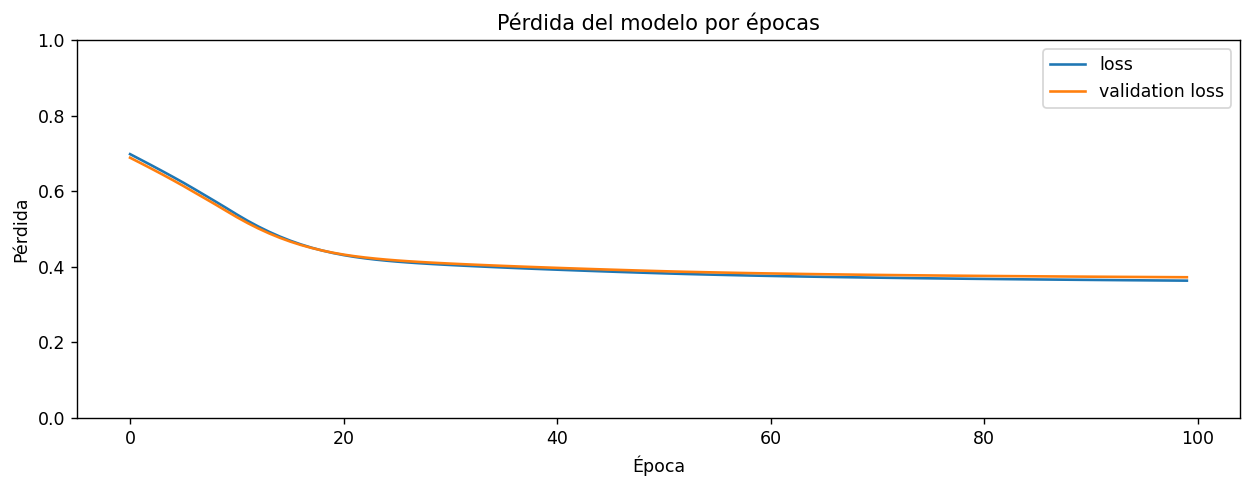

In [29]:
plt.figure(dpi=125, figsize=(12, 4))
plt.plot(h3.history['loss'], label="loss")
plt.plot(h3.history['val_loss'], label="validation loss")
plt.title('Pérdida del modelo por épocas')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.ylim(0, 1)
plt.legend()
plt.show()

Vemos que las curvas están pegadas, eso nos da idea de que el modelo no sobreajuste ni tampoco desajusto.


Veamos las demás métricas.

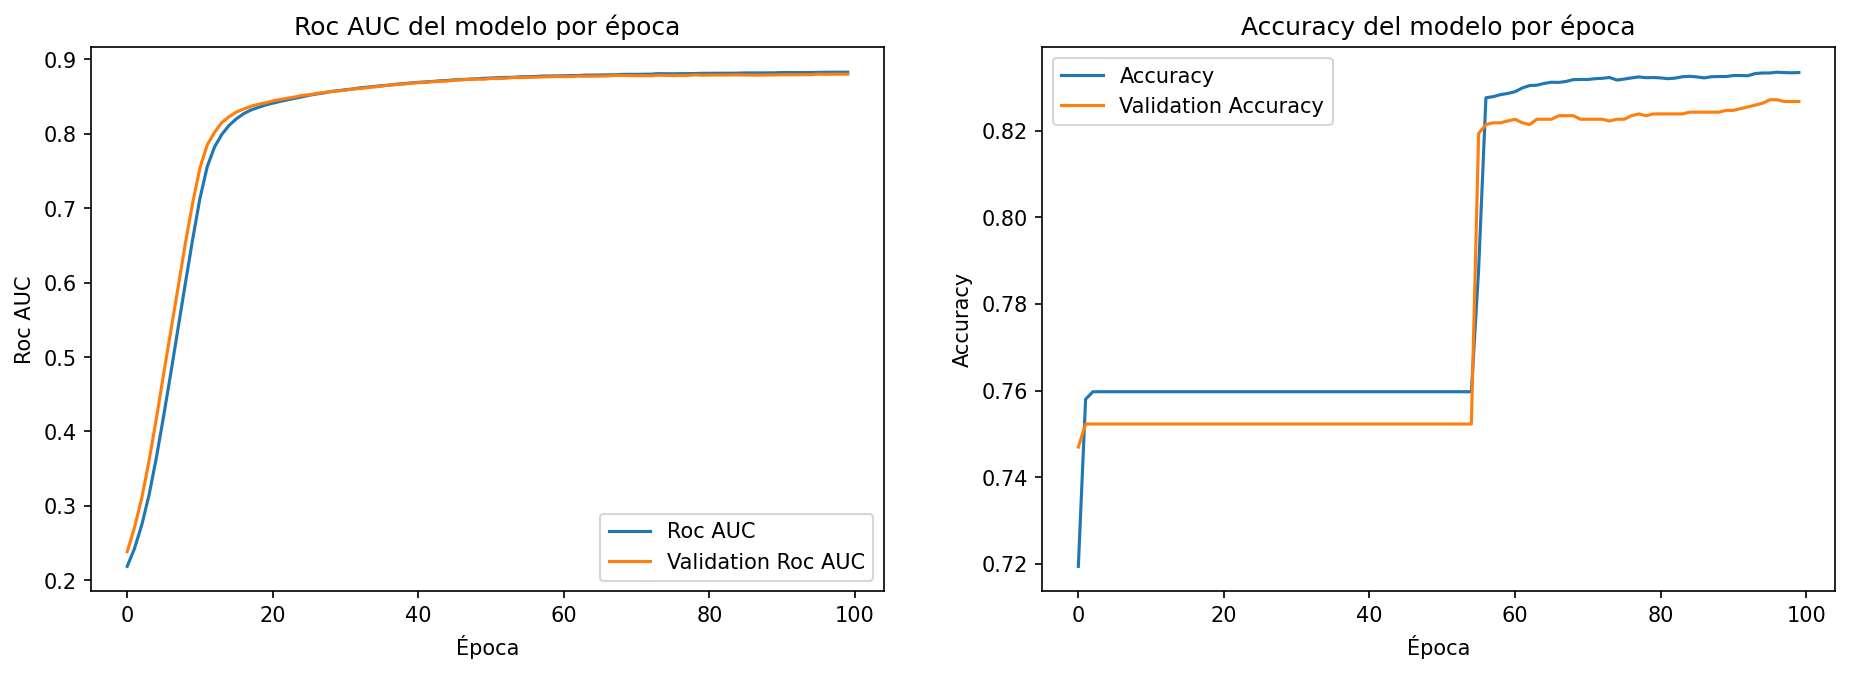

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

ax1.plot(h3.history['auc_2'], label="Roc AUC")
ax1.plot(h3.history['val_auc_2'], label="Validation Roc AUC")
ax1.set_title('Roc AUC del modelo por época')
ax1.set_ylabel('Roc AUC')
ax1.set_xlabel('Época')
ax1.legend()

ax2.plot(h3.history['accuracy'], label="Accuracy")
ax2.plot(h3.history['val_accuracy'], label="Validation Accuracy")
ax2.set_title('Accuracy del modelo por época')

ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Época')
ax2.legend()


plt.show()

Ambas curvas se mantienen pegadas, por lo que deducimos que el modelo realizó un buen trabajo.


Luego, vemos que apartir de la época 80 el RocAUC no parece crecer, y desde la época 40 que el accuracy no parece crecer.

Veamos las métricas de predicción sobre el test.

In [32]:
print(classification_report(y_test_3, m3.predict(X_test_3) > 0.50, digits=4))

              precision    recall  f1-score   support

           0     0.8690    0.9284    0.8977      6186
           1     0.7108    0.5570    0.6246      1955

    accuracy                         0.8392      8141
   macro avg     0.7899    0.7427    0.7612      8141
weighted avg     0.8310    0.8392    0.8321      8141



Se trata entonces de un modelo decente, nada que ya no se haya visto. 83.9% de accuracy. Poca recall para unos como es usual.

Veamos entonces la curva ROC y su puntuación AUC

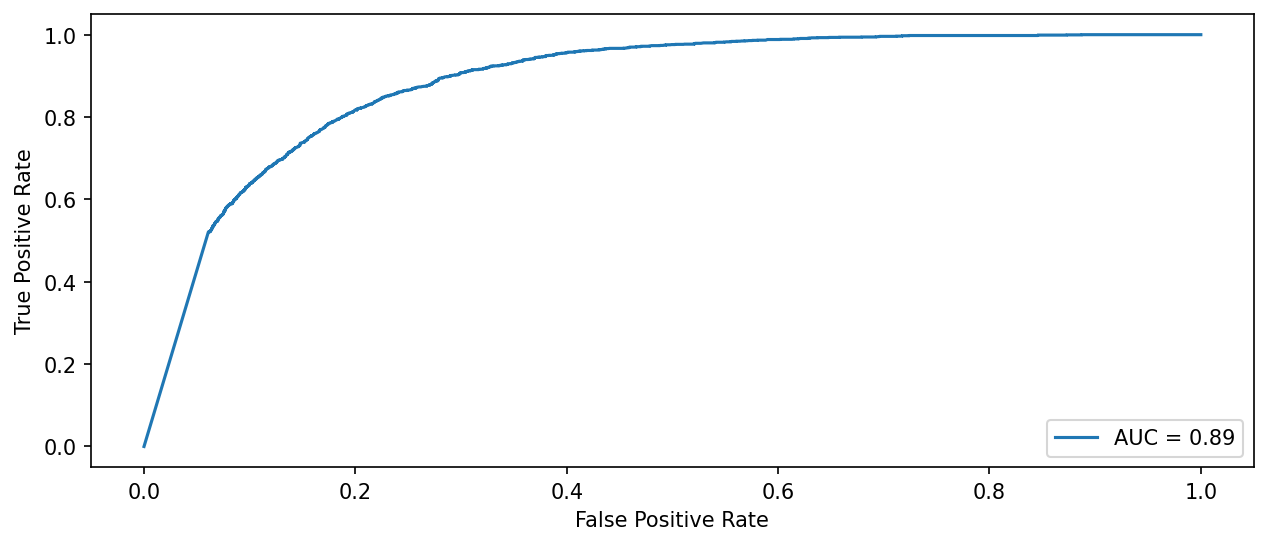

In [34]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)

fpr, tpr, thresholds = roc_curve(y_test_3, m3.predict(X_test_3))
auc = roc_auc_score(y_test_3, m3.predict(X_test_3))

r = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
r.plot(ax=ax)

plt.show()

In [35]:
auc

0.8855788956665616

Un RocAUC de 88.6% es decente, pero se trata del peor modelo conseguido con las redes neuronales.

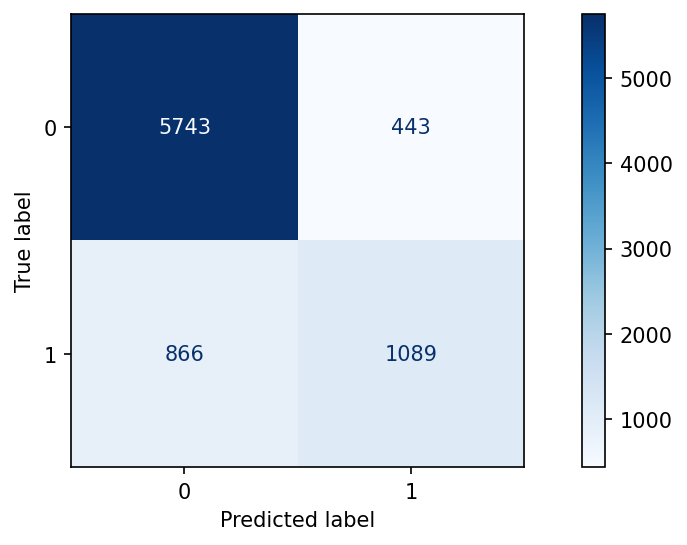

In [47]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
c = ConfusionMatrixDisplay(confusion_matrix(y_test_3, m3.predict(X_test_3)>0.5))
c.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Persistencia de los modelos.

In [43]:
tf.keras.models.save_model(m1, "RedesNeuronales/m1")
tf.keras.models.save_model(m2, "RedesNeuronales/m2")
tf.keras.models.save_model(m3, "RedesNeuronales/m3")

INFO:tensorflow:Assets written to: RedesNeuronales/m1/assets
INFO:tensorflow:Assets written to: RedesNeuronales/m2/assets
INFO:tensorflow:Assets written to: RedesNeuronales/m3/assets


# Predicción de HoldOut

Usaremos para predecir la Red Neuronal obtenida para el preprocessing standardBase.

In [4]:
m2 = loaded_model = tf.keras.models.load_model('Modelos/RedesNeuronales/m2')

In [6]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    ids, X = utils.get_holdout_data()
    
    Xv, X = standard_preprocessing_base_parte_1(Xv, X)
    return ids, X

In [7]:
ids, X = holdout()

In [21]:
utils.escribir_holdout((m2.predict(X)>0.5).flatten().astype(int), "10 - RedesNeuronales", ids)